In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastai.vision.all import *
from fastbook import *
import fastbook
fastbook.setup_book()

matplotlib.rc('image', cmap='Greys')

In [10]:
!pip install nbdev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [nbdev]


# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [13]:
path = untar_data(URLs.MNIST_SAMPLE)
path = untar_data(URLs.MNIST)
path

Path('/Users/explorer/.fastai/data/mnist_png')

In [12]:
doc(URLs)

In [ ]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls()

[Path('valid'), Path('labels.csv'), Path('train')]

In [7]:
(path/'train').ls()

[Path('train/7'), Path('train/3')]

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'), Path('train/3/10000.png'), Path('train/3/10011.png'), Path('train/3/10031.png'), Path('train/3/10034.png'), Path('train/3/10042.png'), Path('train/3/10052.png'), Path('train/3/1007.png'), Path('train/3/10074.png'), Path('train/3/10091.png'), Path('train/3/10093.png'), Path('train/3/10097.png'), Path('train/3/10099.png'), Path('train/3/10116.png'), Path('train/3/10125.png'), Path('train/3/10137.png'), Path('train/3/10141.png'), Path('train/3/10144.png'), Path('train/3/10155.png'), Path('train/3/10161.png'), Path('train/3/10206.png'), Path('train/3/1021.png'), Path('train/3/10210.png'), Path('train/3/10214.png'), Path('train/3/10238.png'), Path('train/3/10260.png'), Path('train/3/10278.png'), Path('train/3/10282.png'), Path('train/3/10314.png'), Path('train/3/10322.png'), Path('train/3/10328.png'), Path('train/3/10329.png'), Path('train/3/10330.png'), Path('train/3/10349.png'), Path('train/3/1035.png'), Path('train/3/10360.png'), Path('train/3/10369.png')

In [9]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

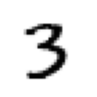

In [14]:
show_image(three_tensors[1]);

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
len(stacked_threes.shape)

3

In [17]:
stacked_threes.ndim

3

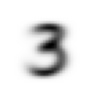

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

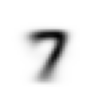

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

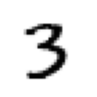

In [20]:
a_3 = stacked_threes[1]
show_image(a_3);

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [24]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [25]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
tns[1]

tensor([4, 5, 6])

In [28]:
tns[:,1]

tensor([2, 5])

In [29]:
tns[1,1:3]

tensor([5, 6])

In [30]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [31]:
tns.type()

'torch.LongTensor'

In [32]:
(tns*1.5).type()

'torch.FloatTensor'

## Computing Metrics Using Broadcasting

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [34]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [36]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [37]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [38]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [40]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [41]:
((a_3/110.96)/(mean3/110.96)).sum()

tensor(nan)

In [42]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [43]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

In [44]:
def f(x): return x**2

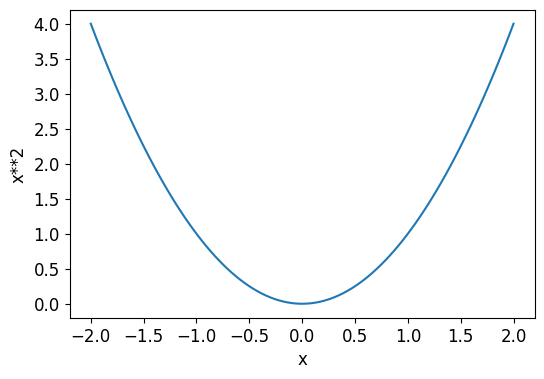

In [45]:
plot_function(f, 'x', 'x**2')

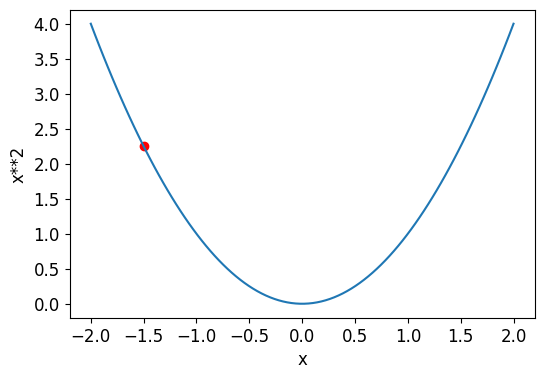

In [46]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [47]:
xt = tensor(3.).requires_grad_()

In [48]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [49]:
yt.backward()

In [50]:
xt.grad

tensor(6.)

In [51]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [52]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [53]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [54]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

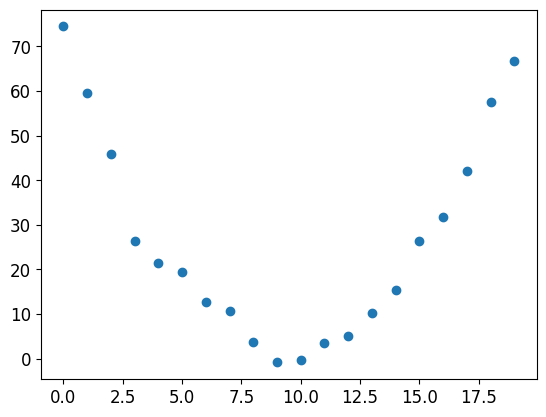

In [55]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [56]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [57]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [58]:
params = torch.randn(3).requires_grad_()

In [59]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [60]:
preds = f(time, params)

In [61]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

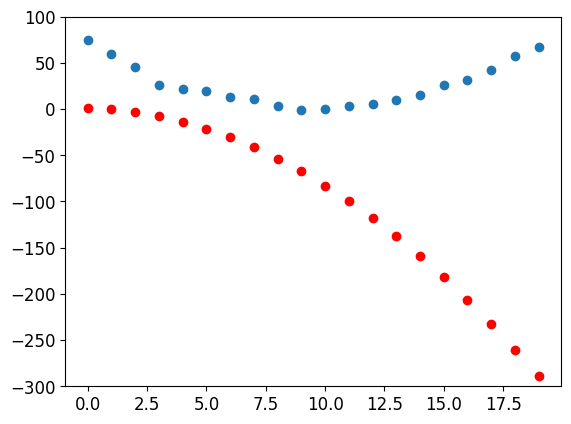

In [62]:
show_preds(preds)

#### Step 3: Calculate the loss

In [63]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [69]:
loss.backward()
params.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [65]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [66]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights. 

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

AttributeError: 'NoneType' object has no attribute 'data'

In [70]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

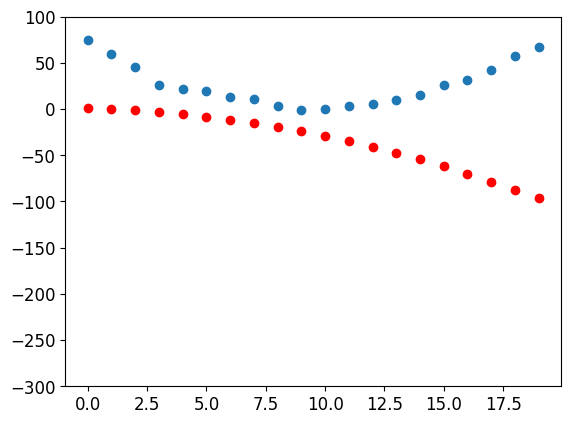

In [71]:
show_preds(preds)

In [ ]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [73]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023193359375
676.9645385742188
676.9537353515625


In [74]:
#hide
params = orig_params.detach().requires_grad_()

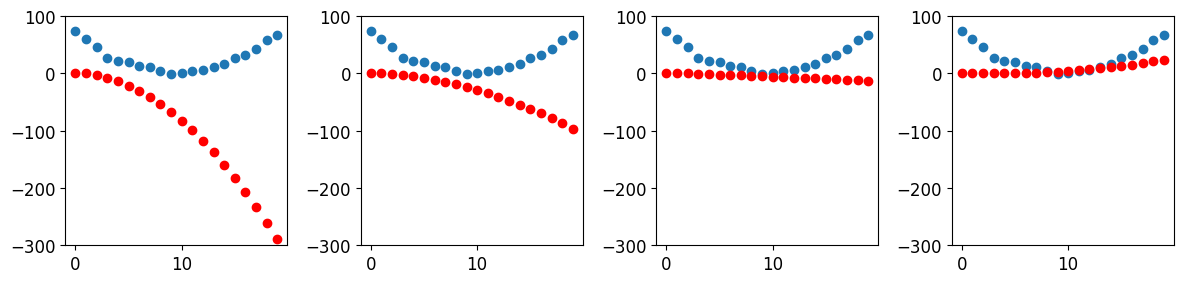

In [75]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [77]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [79]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [80]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [81]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [82]:
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [83]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [144]:
weights = init_params((28*28,1))

In [145]:
bias = init_params(1)

In [146]:
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [87]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [88]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [89]:
preds.shape

torch.Size([12396, 1])

In [90]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [91]:
corrects.float().mean().item()

0.4912068545818329

In [92]:
with torch.no_grad(): weights[0] *= 1.0001

In [93]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

In [94]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [95]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [96]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [97]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [98]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [99]:
def sigmoid(x): return 1/(1+torch.exp(-x))

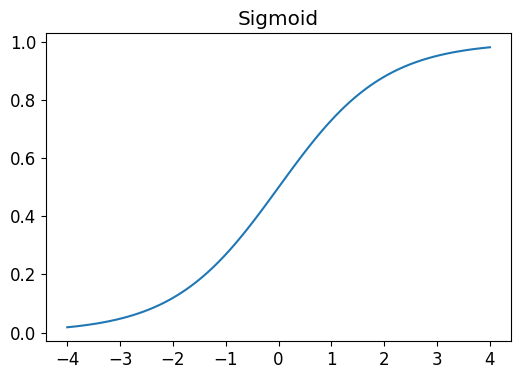

In [100]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [102]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [103]:
ds = L(enumerate(string.ascii_lowercase))
ds

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e'), (5, 'f'), (6, 'g'), (7, 'h'), (8, 'i'), (9, 'j'), (10, 'k'), (11, 'l'), (12, 'm'), (13, 'n'), (14, 'o'), (15, 'p'), (16, 'q'), (17, 'r'), (18, 's'), (19, 't'), (20, 'u'), (21, 'v'), (22, 'w'), (23, 'x'), (24, 'y'), (25, 'z')]

In [104]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

In [57]:
weights = init_params((28*28,1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [58]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

NameError: name 'dset' is not defined

In [59]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [60]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [61]:
preds = linear1(batch)
preds

NameError: name 'linear1' is not defined

In [62]:
loss = mnist_loss(preds, train_y[:4])
loss

NameError: name 'preds' is not defined

In [63]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

NameError: name 'loss' is not defined

In [64]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [65]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

NameError: name 'linear1' is not defined

In [66]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

NameError: name 'linear1' is not defined

In [67]:
weights.grad.zero_()
bias.grad.zero_();

AttributeError: 'NoneType' object has no attribute 'zero_'

In [68]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [69]:
(preds>0.0).float() == train_y[:4]

NameError: name 'preds' is not defined

In [70]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [71]:
batch_accuracy(linear1(batch), train_y[:4])

NameError: name 'linear1' is not defined

In [72]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [73]:
validate_epoch(linear1)

NameError: name 'linear1' is not defined

In [74]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

NameError: name 'linear1' is not defined

In [75]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

NameError: name 'linear1' is not defined

### Creating an Optimizer

In [76]:
linear_model = nn.Linear(28*28,1)

In [77]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [78]:
simple_net = nn.Sequential(
    nn.Linear(28*28,40),
    nn.ReLU(),
    nn.Linear(40,1),
)

In [79]:
for x in simple_net.parameters():
    print(x.shape)
    print('')

torch.Size([40, 784])

torch.Size([40])

torch.Size([1, 40])

torch.Size([1])



In [80]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [81]:
opt = BasicOptim(linear_model.parameters(), lr)

In [82]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [83]:
validate_epoch(linear_model)

0.6405

In [84]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [85]:
train_model(linear_model, 20)

0.4932 0.4932 0.5073 0.6457 0.5101 0.4334 0.43 0.4456 0.439 0.4041 0.4674 0.4672 0.5129 0.4373 0.438 0.4856 0.4652 0.5057 0.5206 0.4834 

In [86]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.2427 0.1749 0.2678 0.2972 0.3275 0.3359 0.3121 0.365 0.3971 0.3431 0.3902 0.4556 0.4365 0.4693 0.4232 0.4659 0.4078 0.462 0.469 0.4573 

In [87]:
dls = DataLoaders(dl, valid_dl)

In [88]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [89]:
lr = 8e-5
learn.fit(250, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.500445,0.504061,0.487242,00:00
1,0.501839,0.504209,0.486261,00:00
2,0.501986,0.504360,0.484789,00:00
3,0.500277,0.504484,0.483808,00:00
4,0.501364,0.504640,0.480864,00:00
5,0.500783,0.504753,0.476447,00:00
6,0.502182,0.504881,0.475466,00:00
7,0.502540,0.505037,0.475957,00:00
8,0.501137,0.505168,0.473994,00:00
9,0.500558,0.505309,0.472031,00:00


## Adding a Nonlinearity

In [90]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [91]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

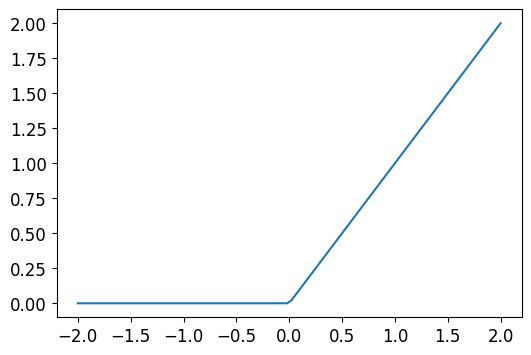

In [92]:
plot_function(F.relu)

In [115]:
simple_net = nn.Sequential(
    nn.Linear(28*28,40),
    nn.ReLU(),
    nn.Linear(40,10),
    nn.ReLU(),
    nn.Linear(10,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

In [117]:
learn.fit(78, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.015950,0.022613,0.504416,00:00
1,0.013294,0.017061,0.504416,00:00
2,0.013010,0.018378,0.504416,00:00
3,0.013398,0.017186,0.504416,00:00
4,0.009100,0.019445,0.504416,00:00
5,0.009013,0.016576,0.504416,00:00
6,0.012636,0.015506,0.504416,00:00
7,0.009517,0.016182,0.504416,00:00
8,0.006586,0.016799,0.504416,00:00
9,0.008673,0.016099,0.504416,00:00


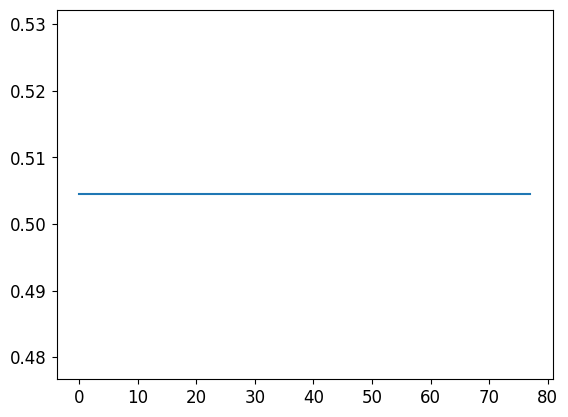

In [118]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [119]:
learn.recorder.values[-1][2]

0.5044161081314087

In [120]:
tensor([[1,2,3],[4,5,6],[7,8,9]])[1:,1:]

tensor([[5, 6],
        [8, 9]])

### Going Deeper

In [183]:
dls = ImageDataLoaders.from_folder(path, device=torch.device("mps"))
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.121124,0.010569,0.998037,00:10


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

### Personal Implementation of Learner

In [121]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

class FlexibleNet:
    _ACTS = {
        "relu": lambda x: x.clamp_min(0.0),
        "sigmoid": torch.sigmoid,
        "tanh": torch.tanh,
        "none": lambda x: x,
        "identity": lambda x: x,
        None: lambda x: x,
    }

    def __init__(self, layer_sizes, activations=None, std=1.0):
        # Example: layer_sizes=[28*28, 30, 1]
        if len(layer_sizes) < 2:
            raise ValueError("layer_sizes must contain at least input and output size")

        n_linear = len(layer_sizes) - 1
        if activations is None:
            activations = ["relu"] * (n_linear - 1) + ["none"]  # hidden=relu, output=linear

        if len(activations) != n_linear:
            raise ValueError(f"Need {n_linear} activations, got {len(activations)}")

        self.weights, self.biases = [], []
        self.activations = activations

        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.weights.append(init_params((n_in, n_out), std))
            self.biases.append(init_params((n_out,), std))

    def model(self, xb):
        x = xb
        for w, b, act_name in zip(self.weights, self.biases, self.activations):
            x = x @ w + b
            act = self._ACTS.get(act_name)
            if act is None:
                raise ValueError(f"Unsupported activation: {act_name}")
            x = act(x)
        return x

    def parameters(self):
        params = []
        for w, b in zip(self.weights, self.biases):
            params.extend([w, b])
        return params

    __call__ = model


In [ ]:
# Loss and Batch Accuracy
def mnist_loss(predictions, y_b):
    predictions = predictions.sigmoid()
    return torch.where(y_b==1, 1-predictions, predictions).mean()

def batch_accuracy(predictions, yb):
    preds = predictions.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [123]:
# Updating weight

class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):

        for p in self.params: 
            p.data -= p.grad.data * self.lr if p.grad is not None else 0.0

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [131]:
class Learning:
    def __init__(self, model, dls, opt_func, loss_func, metrics):
        self.model = model
        self.dl = dls.train
        self.valid_dl = dls.valid
        self.opt = opt_func(model.parameters(), lr=0.001)
        self.loss_func = loss_func
        self.metrics = metrics
    
    def validate_epoch(self,):
        with torch.no_grad():
            accs = [self.metrics(self.model(xb), yb) for xb,yb in self.valid_dl]
        return round(torch.stack(accs).mean().item(), 4)

    def calc_grad(self, xb, yb):
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        loss.backward()

    def train_epoch(self):
        for xb,yb in self.dl:
            self.calc_grad(xb, yb)
            self.opt.step()
            self.opt.zero_grad()

    def train_model(self, epochs):
        for _ in range(epochs):
            self.train_epoch()
            print(self.validate_epoch(), end=' ')

    def fit(self, epochs, lr):
        self.opt.lr = lr
        for _ in range(epochs):
            self.train_epoch()
            print(self.validate_epoch(),)

In [ ]:
# Data Preparation
path = untar_data(URLs.MNIST_SAMPLE)
# path = untar_data(URLs.MNIST)
path

train = {}
valid = {}

for i in [3,7]:
    temp_train = [tensor(Image.open(o)) for o in ((path/f"train/{i}").ls().sorted())]
    temp_valid = [tensor(Image.open(o)) for o in ((path/f"valid/{i}").ls().sorted())]
    train[i] = torch.stack(temp_train).float()/255
    valid[i] = torch.stack(temp_valid).float()/255

    n_train = len(train[i])
    n_valid = len(valid[i])

    print(f"train_{i}: {n_train}, shape: {train[i].shape}")
    print(f"valid_{i}: {n_valid}, shape: {valid[i].shape}")
    print(f"validation_{i}_percent {n_valid/(n_train+n_valid):.4f}")
    print("="*30)

train_x = torch.cat([train[i] for i in [3, 7]]).view(-1, 28*28)
train_y = tensor([1]*len(train[3]) + [0]*len(train[7])).unsqueeze(1)
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
train_dset = list(zip(train_x,train_y))

valid_x = torch.cat([valid[i] for i in [3,7]]).view(-1, 28*28)
valid_y = tensor([1]*len(valid[3]) + [0]*len(valid[7])).unsqueeze(1)
print(f"valid_x shape: {valid_x.shape}, valid_y shape: {valid_y.shape}")
valid_dset = list(zip(valid_x,valid_y))

dl = DataLoader(train_dset, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=16, shuffle=True)

train_3: 6131, shape: torch.Size([6131, 28, 28])
valid_3: 1010, shape: torch.Size([1010, 28, 28])
validation_3_percent 0.1414
train_7: 6265, shape: torch.Size([6265, 28, 28])
valid_7: 1028, shape: torch.Size([1028, 28, 28])
validation_7_percent 0.1410
train_x shape: torch.Size([12396, 784]), train_y shape: torch.Size([12396, 1])
valid_x shape: torch.Size([2038, 784]), valid_y shape: torch.Size([2038, 1])


In [133]:
dls = DataLoaders(dl, valid_dl)

In [154]:
net = FlexibleNet([28*28, 64, 32, 1], activations=["relu", "relu", "none"])
learn = Learning(net, dls, opt_func=BasicOptim,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(epochs=150, lr=0.0553)

0.4956
0.4948
0.4948
0.494
0.4956
0.4948
0.4956
0.4948
0.4956
0.4948
0.4948
0.4932
0.4964
0.4972
0.4956
0.494
0.494
0.494
0.4956
0.4948
0.4964
0.4964
0.4972
0.494
0.4964
0.4948
0.4956
0.4964
0.4956
0.4964
0.4956
0.4964
0.4956
0.4964
0.4948
0.4956
0.4956
0.4972
0.498
0.4972
0.4956
0.4972
0.4948
0.4948
0.4956
0.4956
0.4964
0.4964
0.494
0.4948
0.4948
0.4948
0.494
0.4948
0.4956
0.4956
0.4964
0.494
0.4948
0.494
0.4948
0.498
0.4964
0.4964
0.4956
0.4972
0.4956
0.494
0.4948
0.4948
0.4964
0.4948
0.4956
0.4948
0.4948
0.4948
0.4956
0.4948
0.494
0.494
0.4964
0.4948
0.4948
0.4932
0.4948
0.4948
0.4956
0.4964
0.4956
0.4956
0.4956
0.4964
0.4948
0.4956
0.4972
0.4956
0.4948
0.4948
0.4972
0.4956
0.4956
0.4956
0.4956
0.4932
0.4948
0.4956
0.4956
0.4956
0.4948
0.494
0.4956
0.4964
0.494
0.4964
0.4964
0.494
0.4948
0.494
0.4956
0.4964
0.4948
0.494
0.4964
0.4956
0.4956
0.4972
0.4956
0.4948
0.4964
0.4956
0.4972
0.4964
0.4948
0.4956
0.4964
0.4956
0.4948
0.4956
0.4948
0.494
0.4964
0.4964
0.4956
0.4956
0.4956
0.494

### Mnist Classification Implementation

In [161]:
# Data Preparation
# path = untar_data(URLs.MNIST_SAMPLE)
path = untar_data(URLs.MNIST)
path

train = {}
valid = {}

for i in range(10):
    temp_train = [tensor(Image.open(o)) for o in ((path/f"training/{i}").ls().sorted())]
    temp_valid = [tensor(Image.open(o)) for o in ((path/f"testing/{i}").ls().sorted())]
    train[i] = torch.stack(temp_train).float()/255
    valid[i] = torch.stack(temp_valid).float()/255

    n_train = len(train[i])
    n_valid = len(valid[i])

    print(f"train_{i}: {n_train}, shape: {train[i].shape}")
    print(f"valid_{i}: {n_valid}, shape: {valid[i].shape}")
    print(f"validation_{i}_percent {n_valid/(n_train+n_valid):.4f}")
    print("="*30)

train_x = torch.cat([train[i] for i in range(10)]).view(-1, 28*28)
train_y = torch.cat([torch.full((len(train[i]),), i, dtype=torch.long) for i in range(10)])
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
train_dset = list(zip(train_x,train_y))

valid_x = torch.cat([valid[i] for i in range(10)]).view(-1, 28*28)
valid_y = torch.cat([torch.full((len(valid[i]),), i, dtype=torch.long) for i in range(10)])
print(f"valid_x shape: {valid_x.shape}, valid_y shape: {valid_y.shape}")
valid_dset = list(zip(valid_x,valid_y))

dl = DataLoader(train_dset, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=16, shuffle=True)

train_0: 5923, shape: torch.Size([5923, 28, 28])
valid_0: 980, shape: torch.Size([980, 28, 28])
validation_0_percent 0.1420
train_1: 6742, shape: torch.Size([6742, 28, 28])
valid_1: 1135, shape: torch.Size([1135, 28, 28])
validation_1_percent 0.1441
train_2: 5958, shape: torch.Size([5958, 28, 28])
valid_2: 1032, shape: torch.Size([1032, 28, 28])
validation_2_percent 0.1476
train_3: 6131, shape: torch.Size([6131, 28, 28])
valid_3: 1010, shape: torch.Size([1010, 28, 28])
validation_3_percent 0.1414
train_4: 5842, shape: torch.Size([5842, 28, 28])
valid_4: 982, shape: torch.Size([982, 28, 28])
validation_4_percent 0.1439
train_5: 5421, shape: torch.Size([5421, 28, 28])
valid_5: 892, shape: torch.Size([892, 28, 28])
validation_5_percent 0.1413
train_6: 5918, shape: torch.Size([5918, 28, 28])
valid_6: 958, shape: torch.Size([958, 28, 28])
validation_6_percent 0.1393
train_7: 6265, shape: torch.Size([6265, 28, 28])
valid_7: 1028, shape: torch.Size([1028, 28, 28])
validation_7_percent 0.1410


In [162]:
dls = DataLoaders(dl, valid_dl)

In [163]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

def mnist_loss(predictions, y_b):
    return torch.nn.functional.cross_entropy(predictions, y_b.long())

def batch_accuracy(predictions, yb):
    preds = predictions.argmax(dim=1)
    return (preds == yb).float().mean()

learn = Learner(
    dls, simple_net, opt_func=SGD,
    loss_func=mnist_loss, metrics=batch_accuracy
)

learn.fit(78, 0.01)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.295499,0.320909,0.906900,00:02
1,0.267317,0.257691,0.923000,00:02
2,0.186253,0.204421,0.940200,00:01
3,0.171334,0.177392,0.946800,00:01
4,0.151764,0.145180,0.957000,00:01
5,0.135382,0.126510,0.961200,00:01
6,0.126469,0.119543,0.963400,00:01
7,0.086078,0.105972,0.968400,00:01
8,0.084796,0.098051,0.969800,00:01
9,0.081584,0.090547,0.972800,00:01


In [168]:
img = PILImage.create('/Users/explorer/.fastai/data/mnist_png/testing/9/209.png')
img.to_thumb(500)

In [170]:
learn.predict(temp_valid[0])

RuntimeError: mat1 and mat2 must have the same dtype, but got Byte and Float

### Binary Cross Entropy vs Linear Loss

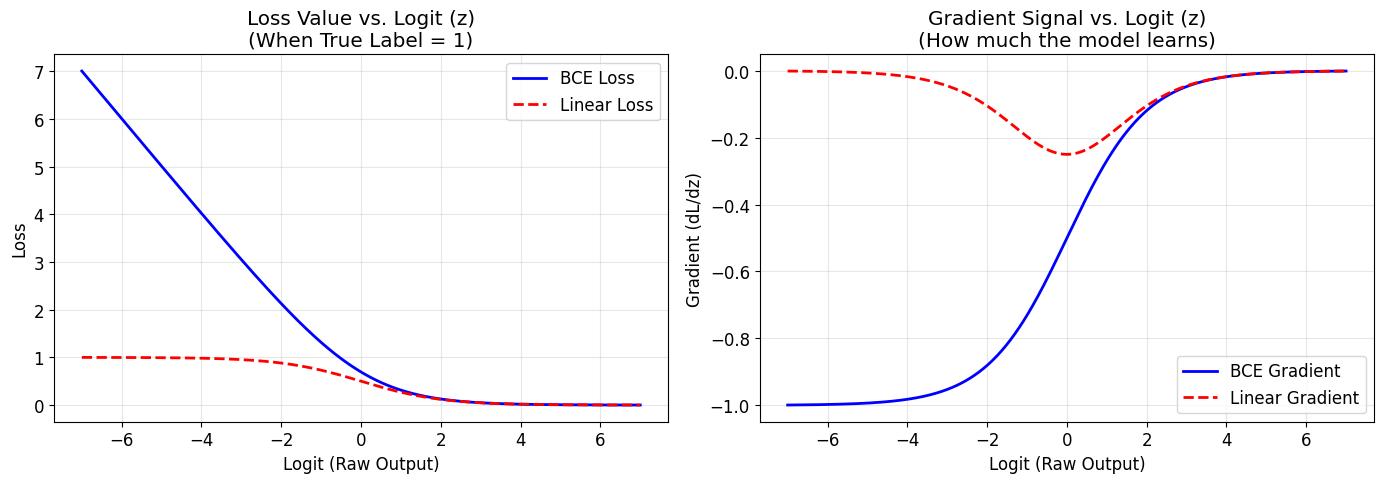

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the range of logits (raw model output)
z = np.linspace(-7, 7, 500)
# 2. Convert logits to probabilities (Sigmoid)
y_pred = 1 / (1 + np.exp(-z))
y_true = 1.0

# --- Loss Functions ---
# Binary Cross Entropy: -[y*log(p) + (1-y)*log(1-p)]
loss_bce = - (y_true * np.log(y_pred + 1e-15)) # added epsilon for stability

# Linear Loss (MAE): |y - p|
loss_linear = np.abs(y_true - y_pred)

# --- Gradient Calculations (dL/dz) ---
# Gradient of BCE w.r.t Logit z is: (y_pred - y_true)
grad_bce = y_pred - y_true

# Gradient of Linear Loss w.r.t Logit z is: -sigmoid'(z) if y=1
# sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
grad_linear = - (y_pred * (1 - y_pred))

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss Values
ax[0].plot(z, loss_bce, label='BCE Loss', color='blue', linewidth=2)
ax[0].plot(z, loss_linear, label='Linear Loss', color='red', linestyle='--', linewidth=2)
ax[0].set_title("Loss Value vs. Logit (z)\n(When True Label = 1)")
ax[0].set_xlabel("Logit (Raw Output)")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(alpha=0.3)

# Plot 2: Gradient (The Learning Signal)
ax[1].plot(z, grad_bce, label='BCE Gradient', color='blue', linewidth=2)
ax[1].plot(z, grad_linear, label='Linear Gradient', color='red', linestyle='--', linewidth=2)
ax[1].set_title("Gradient Signal vs. Logit (z)\n(How much the model learns)")
ax[1].set_xlabel("Logit (Raw Output)")
ax[1].set_ylabel("Gradient (dL/dz)")
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Categorical Cross Entropy vs Multiclass Linear Loss

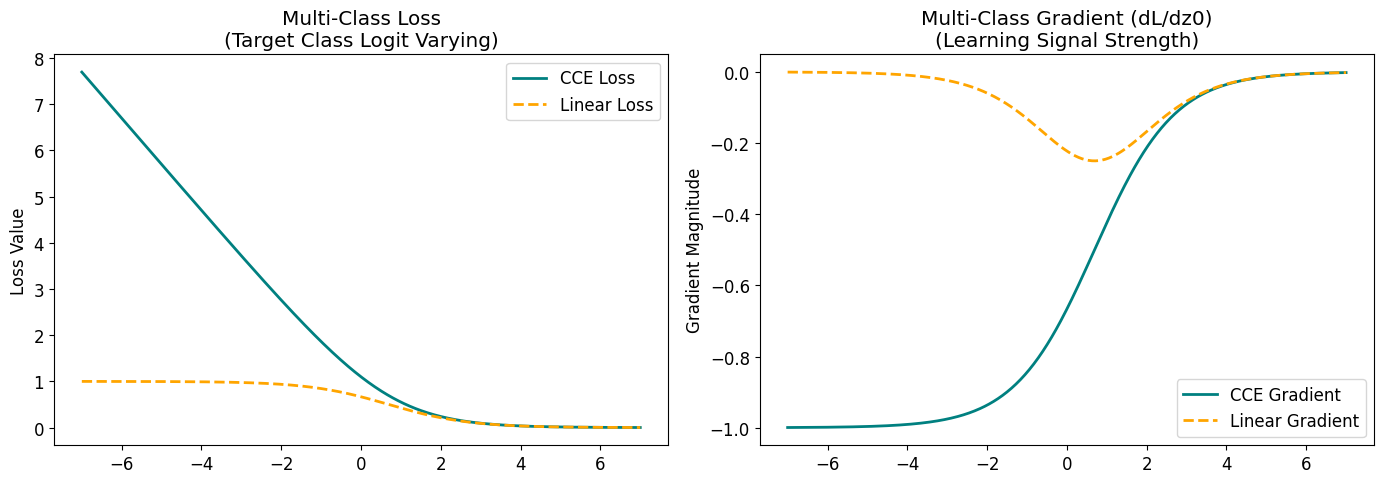

In [156]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(z):
    # Log-sum-exp trick for stability
    e_z = np.exp(z - np.max(z))
    return e_z / e_z.sum()

# Setup: 3 classes, correct class is index 0
y_true = np.array([1, 0, 0])
# We vary the logit of the correct class from -7 to 7
# We keep the other logits constant at 0
logit_range = np.linspace(-7, 7, 500)

losses_cce, grads_cce = [], []
losses_lin, grads_lin = [], []

for z0 in logit_range:
    logits = np.array([z0, 0, 0])
    probs = softmax(logits)
    
    # --- CCE Calculation ---
    l_cce = -np.log(probs[0] + 1e-15)
    g_cce = probs[0] - 1.0 # Gradient w.r.t the correct logit
    
    # --- Linear Calculation ---
    l_lin = 1.0 - probs[0]
    # Gradient of Softmax w.r.t its own logit is p(1-p)
    # Derivative of (1 - p) is -1 * p(1-p)
    g_lin = - (probs[0] * (1.0 - probs[0]))
    
    losses_cce.append(l_cce)
    grads_cce.append(g_cce)
    losses_lin.append(l_lin)
    grads_lin.append(g_lin)

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss Values
ax[0].plot(logit_range, losses_cce, label='CCE Loss', color='teal', lw=2)
ax[0].plot(logit_range, losses_lin, label='Linear Loss', color='orange', ls='--', lw=2)
ax[0].set_title("Multi-Class Loss\n(Target Class Logit Varying)")
ax[0].set_ylabel("Loss Value")
ax[0].legend()

# Plot 2: Gradient Signals
ax[1].plot(logit_range, grads_cce, label='CCE Gradient', color='teal', lw=2)
ax[1].plot(logit_range, grads_lin, label='Linear Gradient', color='orange', ls='--', lw=2)
ax[1].set_title("Multi-Class Gradient (dL/dz0)\n(Learning Signal Strength)")
ax[1].set_ylabel("Gradient Magnitude")
ax[1].legend()

plt.tight_layout()
plt.show()